In this notebook, the key figures included in the results section are generated. To create these figures, data is needed. In the file xxxx, the data is created. 

## Open Exploration

### 'do-nothing' policy
In this section of the notebook, the various plots for the open exploration are created. The open exploration starts with looking at the results of a 'do nothing' policy run, this run will be used to generate scenarios which are used during the directed search. Next, subspace partitioning (PRIM, DS) is applied. Finally, a (global) sensitivity analysis (GSA) is performed using sobol indices. 

# Exploration of the zero-policy run
Firstly, the model has been run using 100 000 scenarios (using LHS) and a 'do nothing' policy. A 'do nothing' policy means that no actions are taken, all model levers have value 0. This answers the question: 'what are the consequences of not taking actions?'

In [16]:
# Import necessary libraries
import pandas as pd 

from ema_workbench.analysis import prim
import matplotlib.pyplot as plt
from SALib.analyze import sobol
from problem_formulation import get_model_for_problem_formulation
dike_model, planning_steps = get_model_for_problem_formulation(2)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# ignore warnings 
import warnings
warnings.filterwarnings("ignore")


# Make sure to display all columns in the DataFrame
pd.set_option('display.max_columns', None)

In [3]:
# load 'do nothing' policy data from the results folder
zero_policy_experiments = pd.read_csv("results/scenario_space_100000_experiments_2025-06-11_21-41.csv")
zero_policy_outcomes = pd.read_csv("results/scenario_space_100000_outcomes_2025-06-11_21-41.csv")

In [4]:
zero_policy_outcomes.head()

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
0,1.121143e+09,0,0.0,0.0,2.001277
1,1.040173e+09,0,0.0,0.0,1.961085
2,3.219446e+09,0,0.0,0.0,3.550581
3,1.400912e+09,0,0.0,0.0,2.822709
4,3.193453e+08,0,0.0,0.0,0.519092


##### Missing part here, ideally @Pien gooi jij hier de resultaten van de zero_policy experiment


### PRIM
Patient Rule Induction Method is applied in this part of the notebook. The data that is used is from a run with 300 scenarios and 400 policies, latin hypercube sampling was used in the uncertainty and lever space. Of interest are uncertainties that lead to a high number of deaths and damages, and policies that lead to a low number of deaths and damages.

In [ ]:
# Load the LHS data to perform the PRIM analysis
data_lhs_experiments = pd.readcsv()
data_lhs_outcomes

In [ ]:
# Set the thresholds 
threshold_value_deaths = 3
threshold_value_damage = 1000


#
x = data_lhs_experiments
# cases of interest have high deaths and high damage

y = (data_lhs_outcomes['Expected Number of Deaths'] > threshold_value_deaths) & (data_lhs_outcomes['Expected Annual Damage'] > threshold_value_deaths)


# initialize PRIM
prim_alg = prim.Prim(x, y)

# search for box
box= prim_alg.find_box()

# show trade-offs between coverage and density
box.show_tradeoff()
plt.show()


### DS


### Sobol Indices
Sobol indices are applied in this part of the notebook on both the uncertainty and lever space. As Sobol sampling is really computationally expensive, only reference scenario and policy are used. The reference scenario has all its uncertainties at the average value and the ID flood wave shape = 4. The reference policy is the 'do-nothing policy' mentioned earlier. 

As our main concerns are the annual damages and deaths, these two outputs are investigated below.


In [49]:
# load Sobol data from the sobol_results folder
SOBOL_policies_experiments = pd.read_csv("sobol_results/SOBOL_policies_experiments_2025-06-18.csv")
SOBOL_policies_outcomes = pd.read_csv("sobol_results/SOBOL_policies_outcomes_2025-06-18.csv")

SOBOL_scenarios_experiments = pd.read_csv("sobol_results/SOBOL_scenarios_experiments_2025-06-18.csv")
SOBOL_scenarios_outcomes = pd.read_csv("sobol_results/SOBOL_scenarios_outcomes_2025-06-18.csv")

print(SOBOL_policies_experiments.shape)

(262144, 53)


In [50]:
problem_scenarios = get_SALib_problem(dike_model.uncertainties)
problem_levers = get_SALib_problem(dike_model.levers)

y_scenarios_deaths = SOBOL_scenarios_outcomes['Expected Number of Deaths'].to_numpy()
y_levers_deaths = SOBOL_policies_outcomes['Expected Number of Deaths'].to_numpy()

Si_uncertainties_deaths = sobol.analyze(problem_scenarios, y_scenarios_deaths, calc_second_order=True, print_to_console=True)
Si_levers_deaths = sobol.analyze(problem_levers, y_levers_deaths, calc_second_order=True, print_to_console=True)

                               ST   ST_conf
A.0_ID flood wave shape  0.009415  0.001125
A.1_Bmax                 0.042815  0.007458
A.1_Brate                0.000263  0.000072
A.1_pfail                0.253409  0.012775
A.2_Bmax                 0.002901  0.001479
A.2_Brate                0.000058  0.000029
A.2_pfail                0.039892  0.006218
A.3_Bmax                 0.000271  0.000108
A.3_Brate                0.000018  0.000012
A.3_pfail                0.823595  0.035747
A.4_Bmax                 0.000020  0.000014
A.4_Brate                0.000003  0.000002
A.4_pfail                0.002547  0.000553
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.024830  0.002216
discount rate 0          0.000000  0.000000
discount rate 1          0.000000  0.000000
discount rate 2          0.000000  0.000000
                               S1   S1_conf
A.0_ID flood wave shape  0.003241  0.004719
A.1_Bmax                 0.00316

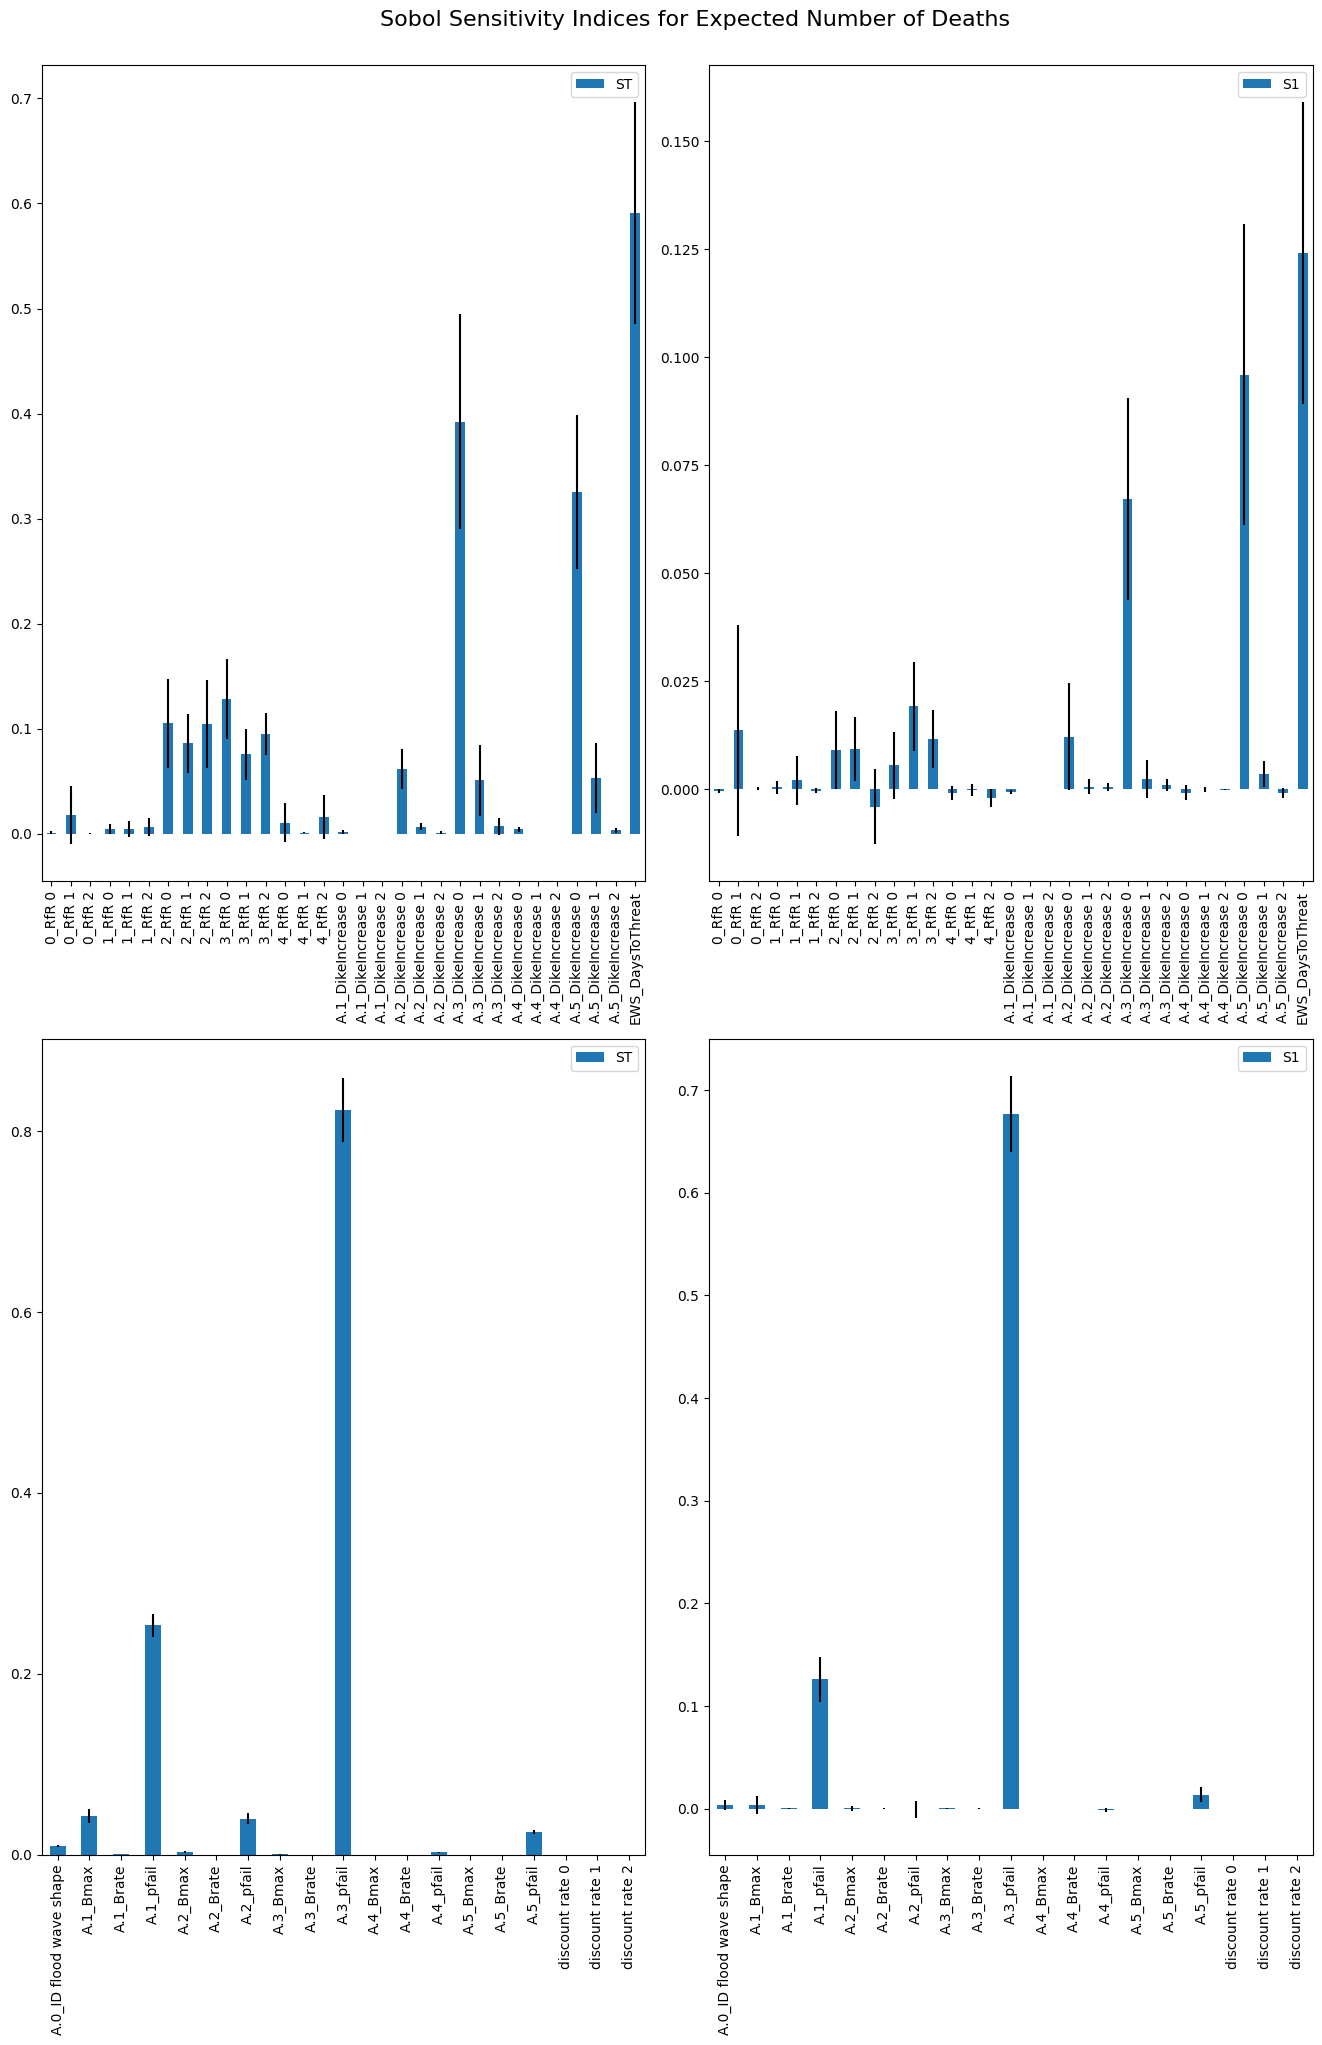

In [ ]:
fig, axes = plt.subplots(2, 3)  # Create a 2x3 grid of subplots
fig.set_size_inches(20, 20)  # Adjust the figure size

# Plot Si_levers on the first row
Si_levers_deaths.plot(ax=axes[0, :])  # Use all three subplots in the first row
fig.delaxes(axes[0, 2])  # Remove the third subplot (S2) in the first row

# Plot Si_uncertainties on the second row
Si_uncertainties_deaths.plot(ax=axes[1, :])  # Use all three subplots in the second row
fig.delaxes(axes[1, 2])  # Remove the third subplot (S2) in the second row

# Adjust layout to remove empty spaces
fig.tight_layout()
# Give title to the figure
fig.suptitle('Sobol Sensitivity Indices for Expected Number of Deaths', fontsize=16, y=1.02, x=0.35)
plt.show()

From the figure above, it becomes apparant that EWS_DaysToThreat is the most important lever to influence and likely lower the expected number of deaths. Furthermore, A.3_DikeIncrease 0 and A.5_DikeIncrease seem promising. 

On the scenario side, the uncertainty of A.3_pfail has the most impact on the number of deaths. A.1_pfail also has a lesser, but still considerable impact.

In [52]:
problem_scenarios = get_SALib_problem(dike_model.uncertainties)
problem_levers = get_SALib_problem(dike_model.levers)

y_scenarios_damage = SOBOL_scenarios_outcomes['Expected Annual Damage'].to_numpy()
y_levers_damage = SOBOL_policies_outcomes['Expected Annual Damage'].to_numpy()

Si_uncertainties_damage = sobol.analyze(problem_scenarios, y_scenarios_damage, calc_second_order=True, print_to_console=True)
Si_levers_damage = sobol.analyze(problem_levers, y_levers_damage, calc_second_order=True, print_to_console=True)

                               ST   ST_conf
A.0_ID flood wave shape  0.006210  0.000602
A.1_Bmax                 0.019840  0.003228
A.1_Brate                0.000127  0.000033
A.1_pfail                0.666659  0.026415
A.2_Bmax                 0.001474  0.000721
A.2_Brate                0.000041  0.000020
A.2_pfail                0.029937  0.002232
A.3_Bmax                 0.000384  0.000184
A.3_Brate                0.000025  0.000016
A.3_pfail                0.269823  0.015919
A.4_Bmax                 0.000023  0.000013
A.4_Brate                0.000003  0.000003
A.4_pfail                0.003162  0.000497
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.034224  0.003737
discount rate 0          0.026259  0.001613
discount rate 1          0.026141  0.001660
discount rate 2          0.026106  0.001795
                               S1   S1_conf
A.0_ID flood wave shape  0.003385  0.003230
A.1_Bmax                 0.00222

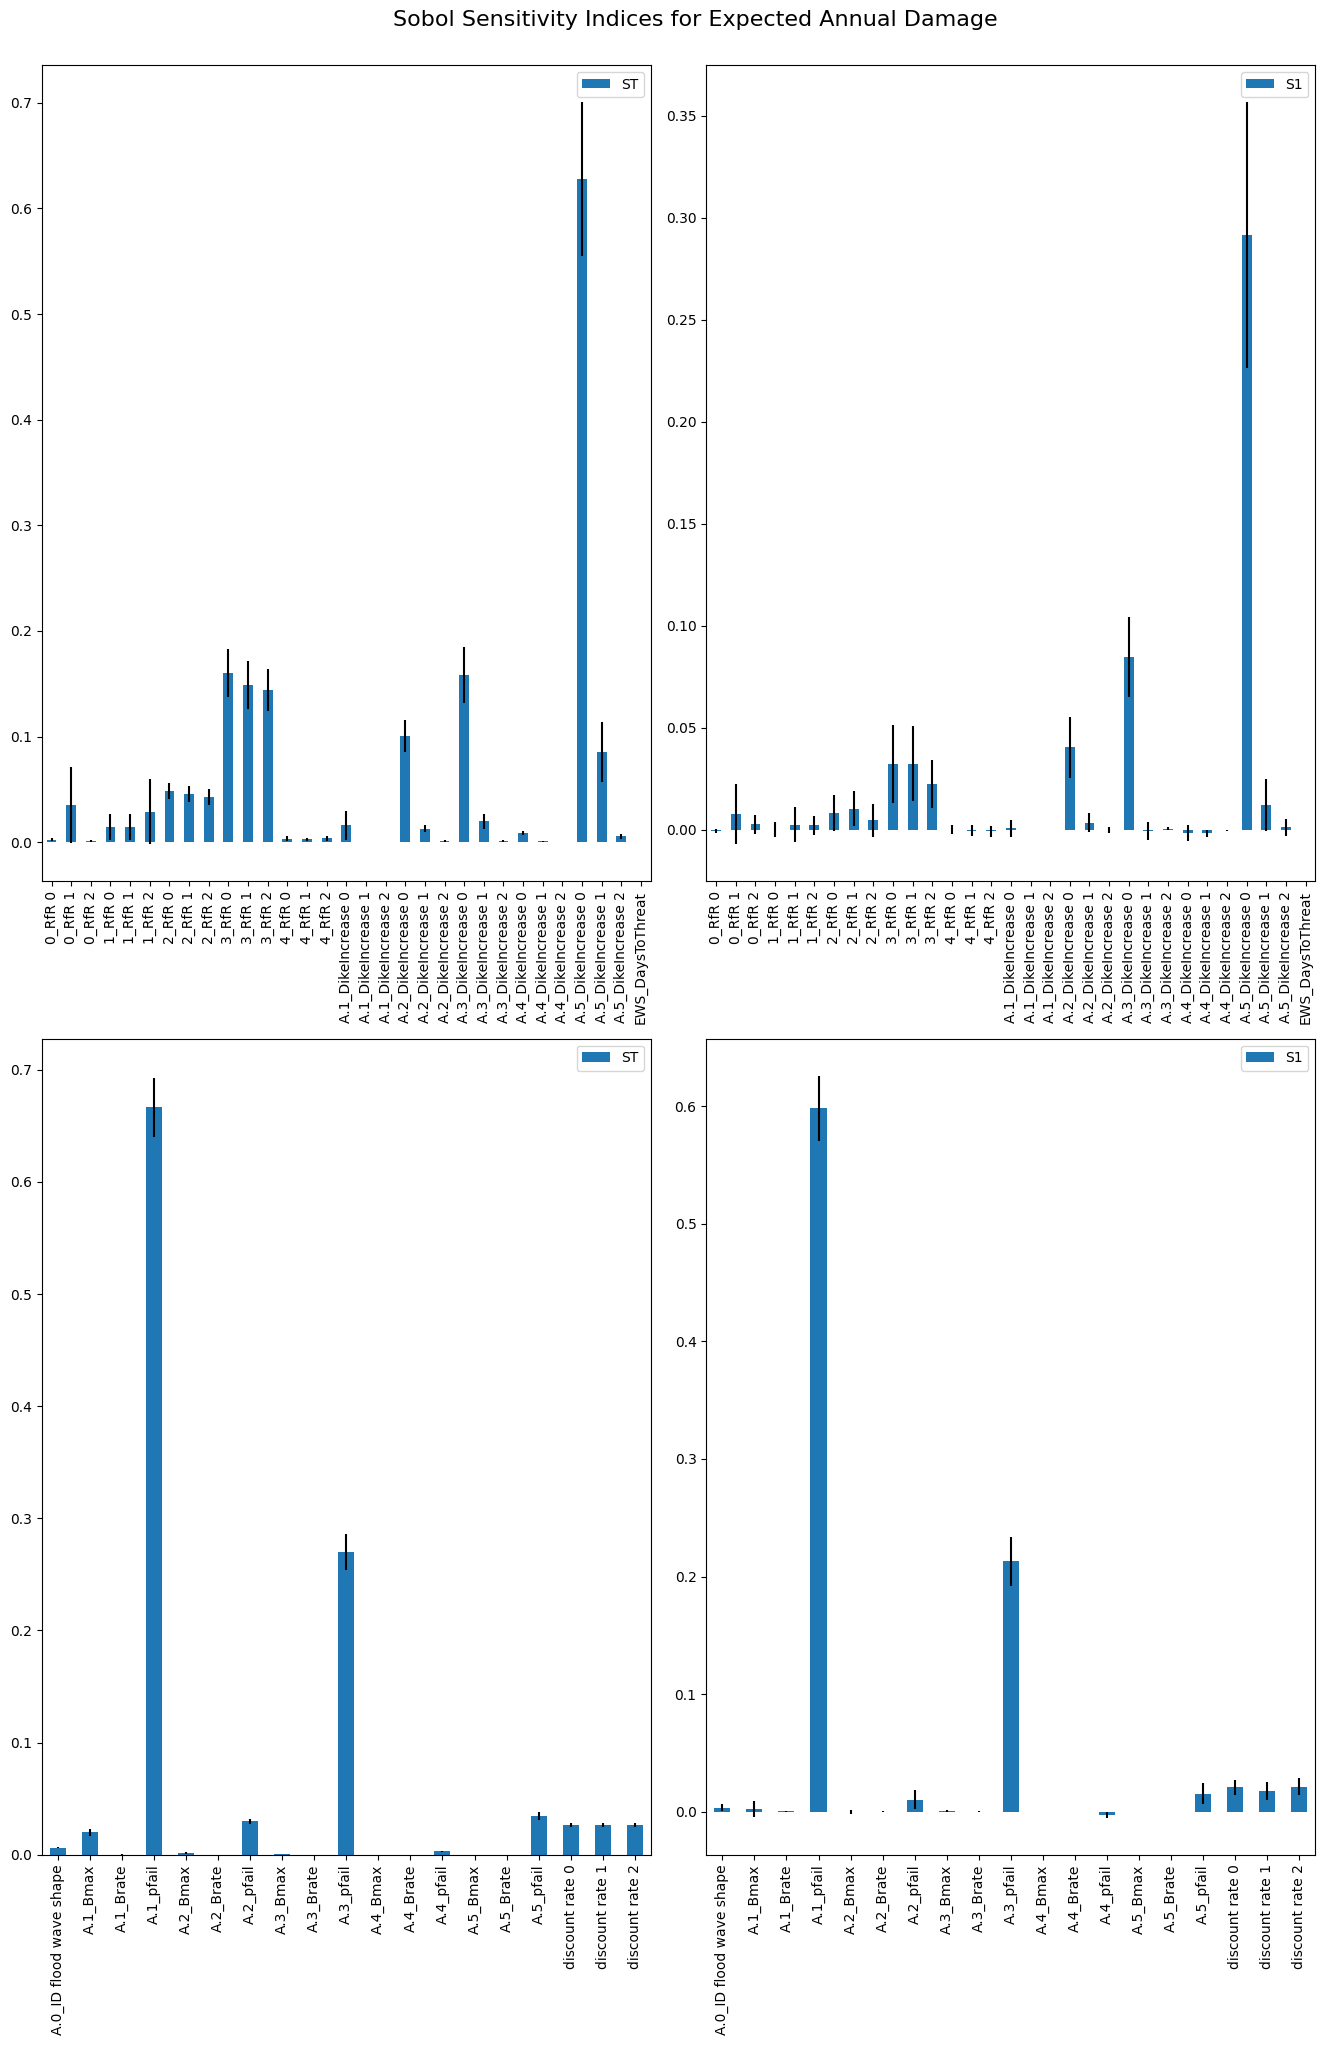

In [53]:
fig, axes = plt.subplots(2, 3)  # Create a 2x3 grid of subplots
fig.set_size_inches(20, 20)  # Adjust the figure size

# Plot Si_levers on the first row
Si_levers_damage.plot(ax=axes[0, :])  # Use all three subplots in the first row
fig.delaxes(axes[0, 2])  # Remove the third subplot in the first row

# Plot Si_uncertainties on the second row
Si_uncertainties_damage.plot(ax=axes[1, :])  # Use all three subplots in the second row
fig.delaxes(axes[1, 2])  # Remove the third subplot in the second row

# Adjust layout to remove empty spaces
fig.tight_layout()
# Give title to the figure

fig.suptitle('Sobol Sensitivity Indices for Expected Annual Damage', fontsize=16, y=1.02, x=0.35)


plt.show()

From the figure above, it becomes apparant that A.5_DikeIncrease is the most important lever to influence the expected amount of damage. Furthermore, A.3_DikeIncrease 0 and 3_RfR also have noticable effects. 

On the scenario side, the uncertainty of A.1_pfail has the most impact on the expected damage. A.3_pfail also has a considerable impact.

## Directed search